In [135]:
import pandas as pd
import numpy as npC
import os

headers = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume(BTC)', 'Volume(Currency)', 'WeightedPrice']
train_X = pd.DataFrame(columns=headers)
test_X = pd.DataFrame(columns=headers)

for filename in os.listdir('../datasets/bitcoin-5')[:20]:
    train_X = pd.concat([train_X, pd.read_csv(f'../datasets/bitcoin-5/{filename}', index_col=False)])
    print("train: ", filename)
    
for filename in os.listdir('../datasets/bitcoin-5')[20:30]:
    test_X = pd.concat([test_X, pd.read_csv(f'../datasets/bitcoin-5/{filename}', index_col=False)])
    print("test: ", filename)

train:  2020-06-01.csv
train:  2020-06-02.csv
train:  2020-06-03.csv
train:  2020-06-04.csv
train:  2020-06-05.csv
train:  2020-06-06.csv
train:  2020-06-07.csv
train:  2020-06-08.csv
train:  2020-06-09.csv
train:  2020-06-10.csv
train:  2020-06-11.csv
train:  2020-06-12.csv
train:  2020-06-13.csv
train:  2020-06-14.csv
train:  2020-06-15.csv
train:  2020-06-16.csv
train:  2020-06-17.csv
train:  2020-06-18.csv
train:  2020-06-19.csv
train:  2020-06-20.csv
test:  2020-06-21.csv
test:  2020-06-22.csv
test:  2020-06-23.csv
test:  2020-06-24.csv
test:  2020-06-25.csv
test:  2020-06-26.csv
test:  2020-06-27.csv
test:  2020-06-28.csv
test:  2020-06-29.csv
test:  2020-06-30.csv


In [243]:
from finta import TA

def preprocess(X, cat=True):
    
    data = pd.DataFrame()

    periods = [10,50,100,200]

    for period in periods:
        data[period] = getattr(TA, 'SMA')(X, period=period)
        
    data['Change'] = X['Close'].diff(periods=12)
    
    macd = TA.MACD(X)
    data['MACD'] = macd['MACD']
    data['SIGNAL'] = macd['SIGNAL']
    data['DIFF'] = macd['MACD'] - macd['SIGNAL']
    
    data['RSI'] = TA.RSI(X, period=14)
    
    data['VOL'] = X['Volume(BTC)']

    #bb = TA.BBANDS(X)
    #data['BB_UPPER'] = bb['BB_UPPER']
    #data['BB_LOWER'] = bb['BB_LOWER']
    #data['BB_DIF'] = bb['BB_UPPER'] - bb['BB_MIDDLE']
    
    if not cat:
        data['Change'] = data['Change'] / X['Close']
    
    data['MOM'] = TA.MOM(X)
    
    data = data.dropna()
    y = data['Change']
    
    if cat:
        y[y > 0] = 1
        y[y < 0] = 0
    
    
    return (data.drop(['Change'], axis=1), y)
    

In [244]:
X_train, y_train = preprocess(train_X)
X_test, y_test = preprocess(test_X)

In [245]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sX_train = scaler.fit_transform(X_train)
sX_test = scaler.fit_transform(X_test)

In [246]:
def test_clf(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    print("training: ", clf.score(X_train, y_train))
    print("testing: ", clf.score(X_test, y_test))

In [247]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

test_clf(DecisionTreeClassifier(), sX_train, y_train, sX_test, y_test)
test_clf(RandomForestClassifier(), sX_train, y_train, sX_test, y_test)

training:  1.0
testing:  0.8205128205128205
training:  1.0
testing:  0.8758825715347455


In [248]:
rf_clf = RandomForestClassifier().fit(sX_train, y_train)

for name, score in zip(X_train.columns, rf_clf.feature_importances_):
    print(name, score)

10 0.03497711455179849
50 0.03381742139426393
100 0.03550488028555166
200 0.034686952711726865
MACD 0.09043591535955836
SIGNAL 0.060925363316447774
DIFF 0.19568009690668436
RSI 0.19845739768682338
VOL 0.03915663614200061
MOM 0.27635822164514456


# Regressions

In [300]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Xr_train, yr_train = preprocess(train_X, cat=False)
Xr_test, yr_test = preprocess(test_X, cat=False)

def plot_preds(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    preds_train = clf.predict(X_train) * -1
    preds_test = clf.predict(X_test) * -1
    scores_train = preds_train + np.array(y_train)
    scores_test = preds_test + np.array(y_test)

    fig, axs = plt.subplots(2, figsize=(10,5))
               
    sns.distplot(scores_train, rug=True, ax=axs[0]).set_title('train')
    sns.distplot(scores_test, rug=True, ax=axs[1]).set_title('test')

def validate_signals(clf, X_train, y_train, X_test, y_test, fit=True):
    
    if fit:
        clf.fit(X_train, y_train)
    
    preds = []
    preds.append(np.array(list(map(lambda x: 0 if x <= 0 else 1, clf.predict(X_train)))))
    preds.append(np.array(list(map(lambda x: 0 if x <= 0 else 1, clf.predict(X_test)))))
    
    actuals = [np.array(list(map(lambda x: 0 if x <= 0 else 1, y_train))), 
               np.array(list(map(lambda x: 0 if x <= 0 else 1, y_test)))]
    
    
    names = ["train: ", "test: "]
    namesp = ["train%: ", "test%: "]
    
    for i, (p, a) in enumerate(zip(preds, actuals)):
        
        print(names[i], len(p[p != a]))
        print(namesp[i], len(p[p != a])/len(p))

    
    

training:  0.9220493528032003
testing:  0.921725684478435


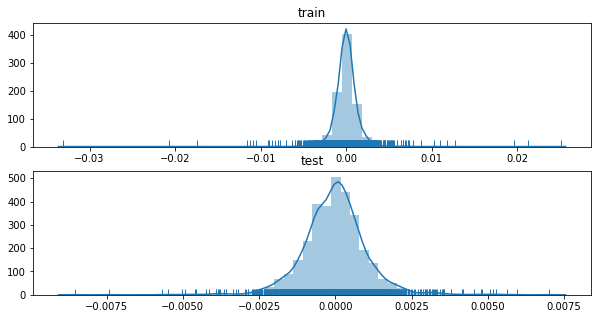

In [301]:
from sklearn.linear_model import LinearRegression

plot_preds(LinearRegression(), Xr_train, yr_train, Xr_test, yr_test)
test_clf(LinearRegression(), Xr_train, yr_train, Xr_test, yr_test)

In [304]:
validate_signals(LinearRegression(), Xr_train, yr_train, Xr_test, yr_test)

train:  661
train%:  0.11843755599354955
test:  287
test%:  0.10665180230397622


# Game

In [486]:
from btcgame import Game, Predictor

play_X = train_X[:2000].copy()

rf_clf = RandomForestClassifier().fit(X_train, y_train)
print(rf_clf.score(X_test, y_test))

0.8602749907097733


In [515]:
from random import randint
class ClassifierPredictor(Predictor):
    
    def __init__(self, **kwargs):
        self.preceding = kwargs.get('preceding', 0)
        self.save = 0
        self.index = 0
        self.history = []

    
    def predict_engine(self, pasts, data):
        
        self.index += 1
        
        if self.save <= self.index:
            
            self.save += 0

            complete_data = pd.DataFrame(pasts + [data], columns=headers[1:])

            X = preprocess(complete_data)[0][-2:]

            assert len(X) == 1

            prediction = rf_clf.predict(X)[0]

            if prediction == 0:
                return (-1, 0.5)
            else:
                return (1, 0.5)
        

        
        return (0, 0)

In [516]:
play_X[195:207]

,Timestamp,Open,High,Low,Close,Volume(BTC),Volume(Currency),WeightedPrice
195,1590941700,9489.0,9520.0,9485.0,9506.6,35.163640,334156.403008,9502.895688
196,1590942000,9512.7,9531.1,9506.5,9524.9,18.476783,175923.212214,9521.311734
197,1590942300,9520.3,9524.9,9515.3,9515.3,7.756987,73845.088440,9519.816020
198,1590942600,9512.0,9520.3,9506.0,9519.0,5.170905,49184.582587,9511.793633
199,1590942900,9521.0,9523.7,9518.6,9520.0,11.448071,109000.259305,9521.277724
200,1590943200,9523.7,9533.7,9514.0,9517.3,2.793471,26591.185696,9519.046814
201,1590943500,9516.9,9517.2,9506.8,9506.8,2.225715,21170.229838,9511.654896
202,1590943800,9506.7,9508.7,9506.7,9507.9,2.863001,27221.441391,9508.009673
203,1590944100,9507.9,9522.9,9507.9,9522.9,19.573581,186106.098212,9508.025120
204,1590944400,9527.9,9529.7,9522.9,9529.7,1.799533,17144.955277,9527.448638


In [517]:
game = Game(test_X[:].astype(float).drop(['Timestamp'], axis=1),
            ClassifierPredictor(preceding=199))
game.play()

,Price,Action,Trade,Cash($),Holding(BTC),Capital($),Capped
0,9301.2,0.0,0.0,200.000000,1.0,9501.200000,0
1,9302.0,0.0,0.0,200.000000,1.0,9502.000000,0
2,9296.6,0.0,0.0,200.000000,1.0,9496.600000,0
3,9311.2,0.0,0.0,200.000000,1.0,9511.200000,0
4,9319.5,0.0,0.0,200.000000,1.0,9519.500000,0
...,...,...,...,...,...,...,...
2885,9185.3,-1.0,0.5,10637.288413,0.0,10637.288413,0.5BTC
2886,9186.5,-1.0,0.5,10637.288413,0.0,10637.288413,0.5BTC
2887,9182.9,-1.0,0.5,10637.288413,0.0,10637.288413,0.5BTC
2888,9185.7,-1.0,0.5,10637.288413,0.0,10637.288413,0.5BTC


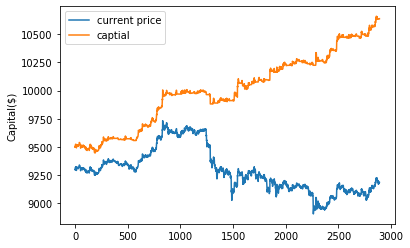

In [518]:
ax = sns.lineplot(x=range(len(game.history)), y=game.history['Price'], label='current price')
sns.lineplot(x=range(len(game.history)), y=game.history['Capital($)'], ax=ax, label='captial')
ax.legend()

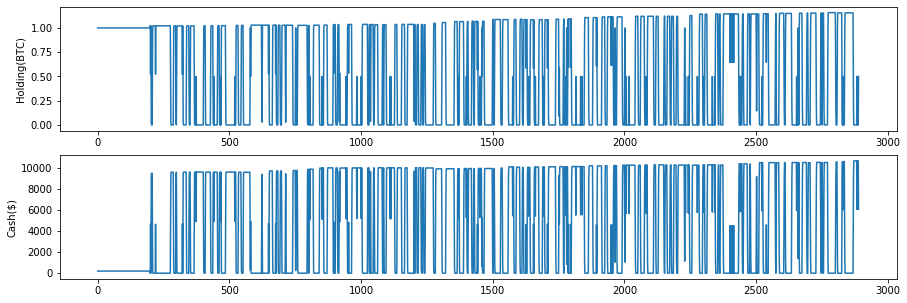

In [519]:
fig, axs = plt.subplots(2, figsize=(15,5))

sns.lineplot(x=range(len(game.history)), y=game.history['Holding(BTC)'], ax=axs[0])
sns.lineplot(x=range(len(game.history)), y=game.history['Cash($)'], ax=axs[1])

In [520]:
game.history['Action'].value_counts()

 1.0    1354
-1.0    1337
 0.0     199
Name: Action, dtype: int64

In [521]:
preprocess(play_X)[1].value_counts()

1.0    943
0.0    858
Name: Change, dtype: int64

In [522]:
rf_clf.predict(preprocess(play_X)[0][10:11])

array([0.])

In [482]:
len(test_X)

2890

In [493]:
len(game.history['Capped'][game.history['Capped'] != 0])

1691